## RAG Agent

In [1]:
from langchain import hub
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_ollama import ChatOllama
from langchain_qdrant import QdrantVectorStore
from langgraph.graph import START, StateGraph
from qdrant_client import QdrantClient
from qdrant_client.models import Filter, FieldCondition, MatchValue
from typing_extensions import List, TypedDict, Annotated, Literal


# set parameters
#---------------------------------------------------------------------------------------
# Qdrant parameters
collection_name = "demo_collection" # name of the Qdrant collection
db_path = "test_rag_db" # path to the Qdrant database

# embedding model parameters
model_name = "sentence-transformers/all-mpnet-base-v2" # embedding model name

# LLM parameters
llm_name = "llama3.1:8b" # name of the LLM model
prompt_extention = "Please provide a detailed answer to the question containing all the information provided in the context." # additional prompt text to get more detailed output
k = 5 # number of documents to retrieve from the RAG database
#---------------------------------------------------------------------------------------


# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")
prompt.messages[0].prompt.template  = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
            Question: {question} 
            Context: {context} 
            Answer:"""

class Search(TypedDict):

    query: Annotated[str, ..., "Search query to run."]
    company: Annotated[
        Literal["loreal", "Beiersdorf"],     # list of all companies in the database (add all companies here), ev also add topic filter
        ...,
        "company to query.",
    ]

# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

# embedding model
embeddings = HuggingFaceEmbeddings(model_name=model_name)

# Define LLM for question-answering
llm = ChatOllama(model=llm_name)

# Initialize the Qdrant client with a local path
client = QdrantClient(path=db_path)

try:
    vector_store = QdrantVectorStore(
        client=client,
        collection_name=collection_name,
        embedding=embeddings,
    )
finally:
    pass
    #client.close()
    
# Define application steps
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=Filter(must=[FieldCondition(key="metadata.company", match=MatchValue(value=query["company"]))]),
        k=k,
    )
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"] + prompt_extention, "context": docs_content})    
    response = llm.invoke(messages)
    return {"answer": response.content}

# Compile application and test
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

c:\Users\Anwender\anaconda3\envs\RAG\lib\site-packages\langsmith\client.py:278: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [28]:
import time
print(time.strftime("%H:%M:%S", time.localtime()))
result = graph.invoke({"question": "Can you tell me if Beiersdorf conducts animal testing?"})


print(f'Metadata: {result["query"]["company"]}')
print(f'Context: {result["context"]}\n\n')
print(f'Answer RAG: {result["answer"]}\n\n')
print(time.strftime("%H:%M:%S", time.localtime()))
print(f'\nAnswer LLM: {llm.invoke("Can you tell me if Beiersdorf conducts animal testing?").content}')
print(time.strftime("%H:%M:%S", time.localtime()))

09:45:59
Metadata: Beiersdorf
Context: [Document(metadata={'company': 'Beiersdorf', 'topic': 'ethics', 'source_file': 'beiersdorf_ethics.json', '_id': 5, '_collection_name': 'demo_collection'}, page_content='certified cruelty-free brand by PETA or the Leaping Bunny program, as its compliance with Chinese regulations means some products may still be subject to animal testing in specific markets. However, the company is a member of the European Partnership for Alternative Approaches to Animal Testing (EPAA), reflecting its investment in non-animal research methods. **Labor Conditions:** Beiersdorf adheres to international labor standards and is a member of the United Nations Global Compact, committing to fair labor practices, human rights, and anti-corruption measures. The company’s 2022 Sustainability Report highlights initiatives to ensure safe working conditions, fair wages, and employee development programs across its supply chain. Independent audits, such as those by the Sedex Membe

In [24]:
client.close()

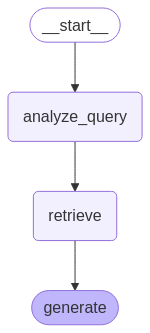

In [4]:
from IPython.display import Image
display(Image(graph.get_graph().draw_mermaid_png()))